In [1]:
import sys
sys.path.append("../")

In [29]:

import shapely
import pyproj
import shapely.ops as ops
from shapely.geometry.polygon import Polygon
from functools import partial


geom = Polygon([(0, 0), (0, 10), (10, 10), (10, 0), (0, 0)])
geom_area = ops.transform(
    partial(
        pyproj.transform,
        pyproj.Proj(init='EPSG:4326'),
        pyproj.Proj(
            proj='aea',
            lat1=geom.bounds[1],
            lat2=geom.bounds[3])),
    geom)

# Print the area in m^2
geom_area.area 

/usr/local/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


CRSError: Invalid projection: +proj=aea +lat1=0.0 +lat2=10.0 +type=crs: (Internal Proj Error: proj_create: Error -21 (conic lat_1 = -lat_2))

In [7]:
import shutil
import rasterio
import fnmatch
import os
from pathlib import Path
from glob import glob
import numpy as np
from ds_exploration.plotting_utils import plot_image

# os.chdir('../sentinelsat/')
from sentinelsat import SentinelAPI
# from sentinelsat import SentinelProductsAPI
os.chdir('../notebooks/')

def make_filter(pattern):
    def node_filter(node_info, include_pattern=pattern):
        return True if fnmatch.fnmatch(node_info["node_path"].lower(), include_pattern) else False
    return node_filter

def unarchive_download(file_path):
    unarchive_dir = file_path.parent
    shutil.unpack_archive(file_path, unarchive_dir)
    os.remove(file_path)

def extract_and_combine(zip_file_path):
    data_path = str(zip_file_path).replace(".zip", ".SAFE")
    band_files = glob(data_path + "/GRANULE/*/IMG_DATA/*.jp2")

    def get_band_array(band, band_files):
        band_file = [bf for bf in band_files if band in bf][0]
        array = rasterio.open(band_file).read(1)
        return array

    red = get_band_array("B04", band_files)
    green = get_band_array("B03", band_files)
    blue = get_band_array("B02", band_files)
    return np.dstack([red, green, blue])

def download_tiles(list_of_tiles,
                   output_folder,
                   user,
                   password,
                   nfilter='*B??.jp2'
                  ):
    if nfilter:
        nodefilter=make_filter(nfilter)
#         api = SentinelProductsAPI(user, password, 'https://scihub.copernicus.eu/dhus')
    
    api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')
    
    try:
        os.mkdir(output_folder)
    except:
        pass
    
    for tile in list_of_tiles:
        print(f'Download tile name: {tile["tile_name"]} for {tile["date"][0]}, {tile["date"][1]}, with filter {nfilter}')
        name = tile['tile_name']
        date = tile['date']
        products = api.query(
            date=date, tileid=name,
            platformname='Sentinel-2', producttype='S2MSI1C'
        )
        if nfilter:
            downloaded_products = api.download_all(products, directory_path=output_folder, n_concurrent_dl=5, nodefilter=nodefilter)
        else:
            downloaded_products = api.download_all(products, directory_path=output_folder, n_concurrent_dl=5)
        
        return downloaded_products
#         print(downloaded_products)
#         filename = [downloaded_products[0][k]['title'] for k in downloaded_products[0].keys()][0]
#         filename = [downloaded_products[0][k]['title'] for k in downloaded_products[0].keys()][0]
#         zip_file_path = Path(f"{output_folder}/{filename}.zip")
#         unarchive_download(zip_file_path)
        
#         rgb = extract_and_combine(zip_file_path)
#         print(rgb.shape)
#         plot_image(rgb, factor=5/2e4, clip_range=(0,1))


In [3]:
# register at https://scihub.copernicus.eu/dhus/#/home
user = 'utsavjha'
password = 'abcdefgh'

In [5]:
list_of_tiles = [
    {'tile_name': "10SEH", 'date': ('20200928', '20200930')},
#     {'tile_name': "10TDK", 'date': ('20201004', '20201009')},
#     {'tile_name': "10TDL", 'date': ('20200928', '20200930')},
]

In [8]:
x=download_tiles(list_of_tiles, "data", user, password, nfilter=None)

Download tile name: 10SEH for 20200928, 20200930, with filter None


Downloading: 100%|██████████| 357M/357M [03:50<00:00, 1.55MB/s] 
MD5 checksumming: 100%|██████████| 357M/357M [00:00<00:00, 578MB/s] 


In [13]:

def area_of_polygon(x, y):
    """Calculates the area of an arbitrary polygon given its verticies"""
    area = 0.0
    for i in range(-1, len(x)-1):
        area += x[i] * (y[i+1] - y[i-1])
    return abs(area) / 2.0


def calculate_area(latitude, longitude):
    """Returns the x & y coordinates in meters using a sinusoidal projection"""
    from math import pi, cos, radians
    earth_radius = 6371009 # in meters
    lat_dist = pi * earth_radius / 180.0

    y = [lat * lat_dist for lat in latitude]
    x = [long * lat_dist * cos(radians(lat))
         for lat, long in zip(latitude, longitude)]

    area = area_of_polygon(x,y)
    return area


def determine_polygon_area(polygon_coordinates):
    for lat, long in polygon_coordinates:
        area = calculate_area(lat, long)
        print (area)

In [19]:
polygon_coordinates = [x[0][item]["footprint"] for item in x[0].keys()][0]
polygon_coordinates

'POLYGON((-122.24843 38.84492814517761,-122.280365 38.75319183686564,-122.33087 38.60676360025349,-122.3802 38.46006574089602,-122.43063 38.3136854644201,-122.47995 38.16713621610586,-122.50545 38.091306414180686,-122.52957 38.019766740690606,-122.579285 37.87332519483883,-122.58467 37.85724036165807,-123.00023 37.85944195932729,-123.00023 38.848998483821255,-122.24843 38.84492814517761))'

In [36]:
nums = polygon_coordinates[9:].split(',')
nums

['-122.24843 38.84492814517761',
 '-122.280365 38.75319183686564',
 '-122.33087 38.60676360025349',
 '-122.3802 38.46006574089602',
 '-122.43063 38.3136854644201',
 '-122.47995 38.16713621610586',
 '-122.50545 38.091306414180686',
 '-122.52957 38.019766740690606',
 '-122.579285 37.87332519483883',
 '-122.58467 37.85724036165807',
 '-123.00023 37.85944195932729',
 '-123.00023 38.848998483821255',
 '-122.24843 38.84492814517761))']

In [38]:

pg_coordinates = []
for item in nums:
    lat, lon = item.split(' ')
    lon = lon[:10]
    some_tupe = (float(lat), float(lon))
    pg_coordinates.append(some_tupe)

pg_coordinates
#     area = calculate_area(lat, lon)
#     print(f"Area {lat}, {lon}     =    {area}")

[(-122.24843, 38.8449281),
 (-122.280365, 38.7531918),
 (-122.33087, 38.6067636),
 (-122.3802, 38.4600657),
 (-122.43063, 38.3136854),
 (-122.47995, 38.1671362),
 (-122.50545, 38.0913064),
 (-122.52957, 38.0197667),
 (-122.579285, 37.8733251),
 (-122.58467, 37.8572403),
 (-123.00023, 37.8594419),
 (-123.00023, 38.8489984),
 (-122.24843, 38.8449281)]

In [46]:
pg = Polygon(pg_coordinates)

pg.bounds

(-123.00023, 37.8572403, -122.24843, 38.8489984)

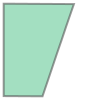

In [63]:
pg

In [64]:
# !pip install geopy
!{sys.executable} -m pip install geopy
!{sys.executable} -m pip install pillow

You should consider upgrading via the '/usr/local/opt/python/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/opt/python/bin/python3.7 -m pip install --upgrade pip' command.


In [62]:
import geopy

import geopy.distance
width = geopy.distance.geodesic((pg.bounds[1], pg.bounds[0]),(pg.bounds[1], pg.bounds[2])).kilometers
height = geopy.distance.geodesic((pg.bounds[1], pg.bounds[0]),(pg.bounds[3], pg.bounds[0])).kilometers

width
height

110.08829879958837

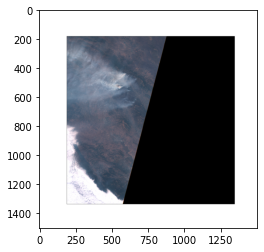

In [78]:
from PIL import Image 
im = Image.open("/Users/utsavkumarjha/Desktop/self/code/satellite/lib/src/data/plots/S2B_MSIL1C_20200929T190109_N0209_R013_T10SEH_20200929T213343.png")
image = np.array(im)
image.shape
plt.imshow(image)

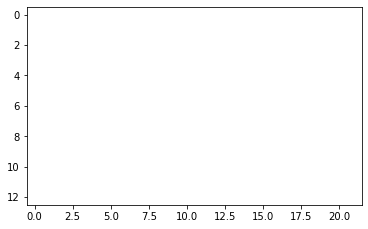

In [76]:
import matplotlib.pyplot as plt
cut_images = []

h_chunk = int(image.shape[0] / height)
w_chunk = int(image.shape[1] / width)
for h in range(int(height)):
    for w in range(int(width)):
        image_cut = image[h_chunk*h:h_chunk*(h+1), w_chunk*w:w_chunk*(w+1), :]
        
        cut_images.append(image_cut )

plt.imshow(cut_images[200])

In [ ]:
from skimage.util import view_as_blocks

blocks = view_as_blocks(rgb, block_shape=(1098, 1098, 3))
plot_image(blocks[1,1][0, :, :, :], factor=5/2e4, clip_range=(0,1), figsize=(5, 5))

In [ ]:
from skimage.transform import rescale

scaled = rescale(blocks[1,1][0, :, :, :] , scale=0.2, preserve_range=True, multichannel=True)
print(scaled.shape, blocks[1,1][0, :, :, :].shape)
plot_image(scaled, factor=5/2e4, clip_range=(0,1), figsize=(5, 5))